# Catégorisez les produits d'un site d'e-commerce: Classification des images

* [1. Import et chargement des données](#10)
    * [1.1 Import des librairies](#11)
    * [1.2 Chargement des données](#12)
    * [1.3 Transformation des labels](#13)
* [2. Classification des images avec un CNN](#20)
    * [2.1 Création de la fonction de réentrainement du modèle](#21)
    * [2.2 Préprocessing des images et labels](#22)
    * [2.3 Réentrainement du modèle](#23)
    * [2.4 Classification supervisée des images](#24)
    * [2.5 Analyse des prédictions du modèle](#25)
* [3. Conclusion](#30)

<h1 id='10'>1. Import et chargement des données</h1>

<h2 id='11'>1.1 Import des librairies</h2>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


<h2 id='12'>1.2 Chargement des données</h2>

In [2]:
image_path = os.getcwd() + "\\flipkart\\images\\"

In [3]:
df = pd.read_csv("flipkart\\flipkart_com-ecommerce_sample_1050.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<h2 id='13'>1.3 Transformation des labels</h2>

In [4]:
df["main_category"] = df['product_category_tree'].str.split(" >> ").str[0].str.replace('["', '')
df['main_category'].value_counts()

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

<h1 id='20'>2. Classification des images avec un CNN</h1>

<h2 id='21'>2.1 Création de la fonction de réentrainement du modèle</h2>

In [5]:

def create_model(n_classes:int) :
    # Récupération modèle pré-entraîné
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in base_model.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = base_model.output
    # Compléter le modèle
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=base_model.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

<h2 id='22'>2.2 Préprocessing des images et labels</h2>

In [6]:
y = df['main_category']
X = df['image']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=42, stratify=y_train)

In [7]:
def image_preprocessing(data, path_col:str) :
    preprocessed_images = []
    for path in data:#[path_col] :
        img = load_img(image_path+path,target_size=(224, 224))
        img = img_to_array(img)
        #img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        preprocessed_images.append(img)
    preprocessed_images = np.array(preprocessed_images)
    return preprocessed_images
    
X_train = image_preprocessing(X_train, "image")
print(X_train.shape)
X_val = image_preprocessing(X_val, "image")
print(X_val.shape)
X_test = image_preprocessing(X_test, "image")
print(X_test.shape)

c:\Users\petit\anaconda3\envs\flipkart\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(630, 224, 224, 3)
(210, 224, 224, 3)
(210, 224, 224, 3)


In [8]:
n_classes = df['main_category'].nunique()

items_dic_code = {key:index for index, key in enumerate(y_train.unique())}
reverse_dic = {value:key for key, value in items_dic_code.items()}

y_train = np.array([items_dic_code[i] for i in y_train])
y_val = np.array([items_dic_code[i] for i in y_val])
y_test = np.array([items_dic_code[i] for i in y_test])

y_train = to_categorical(y_train, num_classes=n_classes)
y_val = to_categorical(y_val, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

<h2 id='23'>2.3 Réentrainement du modèle</h2>

In [9]:
model = create_model(df["main_category"].nunique())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,271 (80.64 MB)

 Trainable params: 6,424,583 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [10]:
aug = ImageDataGenerator(rotation_range=25, horizontal_flip=True)

In [11]:
h = model.fit(aug.flow(X_train, y_train, batch_size=32),
              validation_data=(X_val, y_val),
              epochs=5
              )

c:\Users\petit\anaconda3\envs\flipkart\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.4005 - loss: 35.2999 - val_accuracy: 0.8238 - val_loss: 5.2650
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.7763 - loss: 4.8771 - val_accuracy: 0.8381 - val_loss: 2.5360
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7847 - loss: 2.0812 - val_accuracy: 0.7905 - val_loss: 1.5645
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8136 - loss: 1.2916 - val_accuracy: 0.8143 - val_loss: 1.4446
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7757 - loss: 0.9819 - val_accuracy: 0.8286 - val_loss: 1.8832


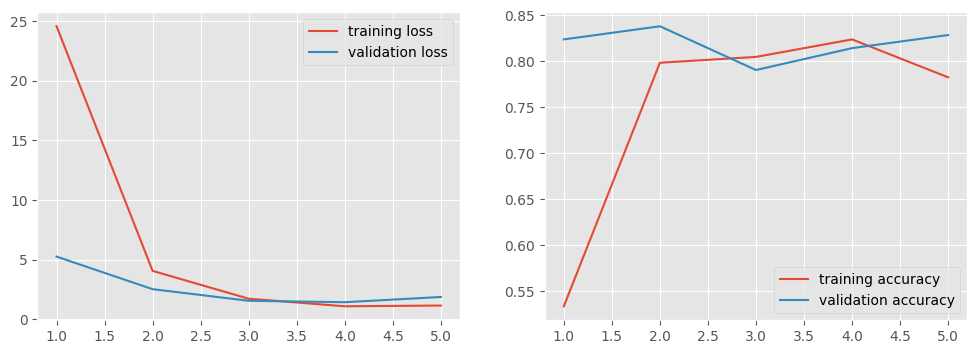

In [ ]:
n_epochs = 5

fig, ax = plt.subplots(1,2, figsize=(12,4))

fig_range = np.arange(1, n_epochs+1)

sns.lineplot(x=fig_range, y=h.history['loss'], ax=ax[0], label='training loss')
sns.lineplot(x=fig_range, y=h.history['val_loss'], ax=ax[0], label='validation loss')

sns.lineplot(x=fig_range, y=h.history['accuracy'], ax=ax[1], label='training accuracy')
sns.lineplot(x=fig_range, y=h.history['val_accuracy'], ax=ax[1], label='validation accuracy')

plt.show()

<h2 id='24'>2.4 Classification supervisée des images</h2>

In [13]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(y) for y in y_pred]
y_pred = np.array(y_pred)

y_t = [np.argmax(y) for y in y_test]
y_t = np.array(y_t)

conf_mat = confusion_matrix(y_t, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


<h2 id='25'>2.5 Analyse des prédictions du modèle</h2>

In [14]:
print(classification_report(y_t, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.53      0.57        30
           1       0.74      0.93      0.82        30
           2       0.65      0.67      0.66        30
           3       0.96      0.90      0.93        30
           4       0.59      0.77      0.67        30
           5       0.77      0.67      0.71        30
           6       0.91      0.67      0.77        30

    accuracy                           0.73       210
   macro avg       0.75      0.73      0.73       210
weighted avg       0.75      0.73      0.73       210



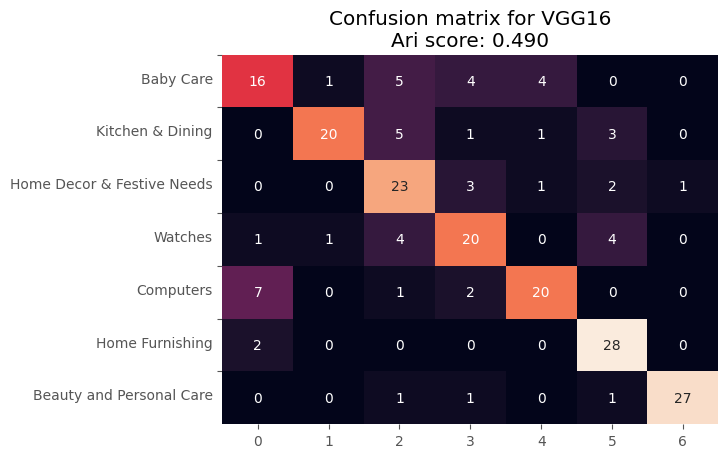

In [15]:
y_p = [reverse_dic[y] for y in y_pred]
y_t2 = [reverse_dic[y] for y in y_t]

conf_mat = confusion_matrix(y_t2, y_p)

matrix_label = list(items_dic_code)
matrix_label = ["\n\n\n"+l for l in matrix_label]

ari = adjusted_rand_score(y_t2, y_p)

sns.heatmap(conf_mat, annot=True, fmt=".0f", cbar=None)
plt.title(f"Confusion matrix for VGG16\nAri score: {ari:.3f}")
plt.yticks(ticks=range(7), labels=matrix_label, rotation=0);

<h1 id='30'>3. Conclusion</h1>



Réutiliser les poids du modèle entraîné avec Imagenet nous permet d'obtenir un meilleur résultat que l'extraction des features des images avec le même réseau de neurones à convolutions.

L'accuracy du modèle sur le jeu de test est de 0,79 et nous obtenons un score ARI de 0,49